In [11]:
from capymoa.drift.detectors import ADWIN
from capymoa.classifier import HoeffdingTree
from capymoa.base import Classifier

class DriftDetectionClassifier(Classifier):
    def __init__(self, classifier, drift_detector):
        # delegating schema and random_seed to be set by the 'classifier'
        super().__init__(schema=classifier.schema, random_seed=classifier.random_seed)

        self.classifier = classifier
        self.drift_detector = drift_detector
        # save the args in case we need to reset the classifier later
        self.classifier_args = self._get_init_args(classifier)

        # Simple counter so that you can make sense of the detections
        self.instances_seen = 0
        
    def __str__(self):
        return 'DriftDetectionClassifier'

    def train(self, instance):
        self.instances_seen += 1        
        # monitors the correct/incorrect predictions
        pred = self.classifier.predict(instance)
        y = instance.y_index
        pred_equals_y = 1 if pred == y else 0
        
        self.drift_detector.add_element(pred_equals_y)

        # trigger a drift
        if self.drift_detector.detected_change():
            print(f'Change detected at instance: {self.instances_seen}')
            self.reset()

        self.classifier.train(instance)

    def reset(self, schema=None):
        # obtain the class of the classifier and create a new one using the arguments saved before
        # print(type(**self.classifier_args))

        if schema is not None:
            self.classifier_args['schema'] = schema
        print (self.classifier_args)
        self.classifier = self.classifier.__class__(schema=self.schema)
        
        
        self.classifier.__class__(**self.classifier_args)

    def predict(self, instance):
        return self.classifier.predict(instance)

    def predict_proba(self, instance):
        return self.classifier.predict_proba(instance)

    def _get_init_args(self, obj):
        # filter only the arguments needed for initialization
        init_args = {}
        for param in obj.__init__.__code__.co_varnames:
            if param in obj.__dict__:
                init_args[param] = obj.__dict__[param]
        return init_args

Change detected at instance: 992
{'schema': @relation 'generators.SEAGenerator '

@attribute attrib1 numeric
@attribute attrib2 numeric
@attribute attrib3 numeric
@attribute class {groupA,groupB}

@data, 'random_seed': 0}
Change detected at instance: 14816
{'schema': @relation 'generators.SEAGenerator '

@attribute attrib1 numeric
@attribute attrib2 numeric
@attribute attrib3 numeric
@attribute class {groupA,groupB}

@data, 'random_seed': 0}
cumulative accuracy HT: 86.13333333333333 and DDC: 86.27333333333334


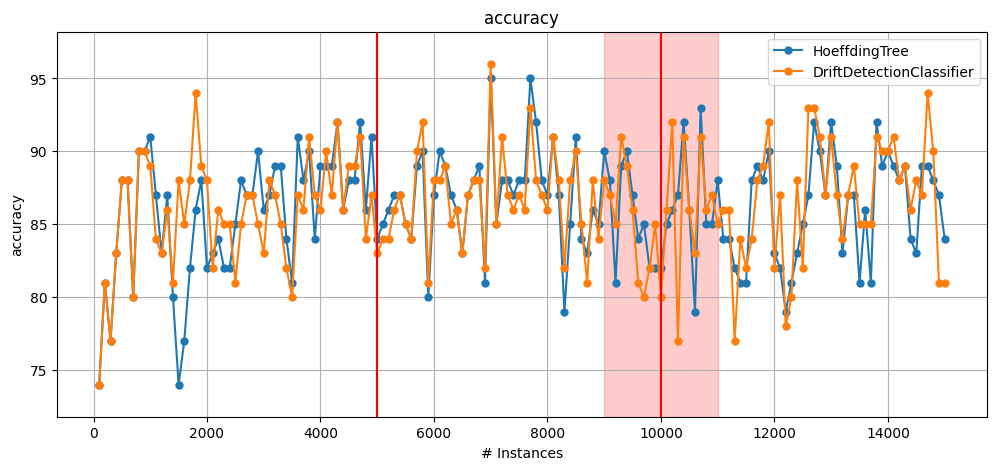

In [13]:
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import SEA
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import HoeffdingTree

stream_sea2drift = DriftStream(stream=[SEA(function=1), 
                                AbruptDrift(position=5000), 
                                SEA(function=3), 
                                GradualDrift(position=10000, width=2000), 
                                # GradualDrift(start=9000, end=12000),
                                SEA(function=1)])

# create the learner and detector
ht = HoeffdingTree(schema=stream_sea2drift.get_schema(), grace_period=50)

# Change ADWIN delta to adjust the detection sensibility
ddc = DriftDetectionClassifier(
    classifier=HoeffdingTree(schema=stream_sea2drift.get_schema(), grace_period=50), 
    drift_detector=adwin = ADWIN(delta=0.1)
)

results_sea2drift_ht = prequential_evaluation(stream=stream_sea2drift, learner=ht, window_size=100, max_instances=15000)
results_sea2drift_ddc = prequential_evaluation(stream=stream_sea2drift, learner=ddc, window_size=100, max_instances=15000)

print(f"cumulative accuracy HT: {results_sea2drift_ht.cumulative.accuracy()} and DDC: {results_sea2drift_ddc.cumulative.accuracy()}")
plot_windowed_results(results_sea2drift_ht, results_sea2drift_ddc, metric='accuracy')

## Example modifying the Schema

In [22]:
from capymoa.stream.drift import DriftStream, Drift, AbruptDrift, GradualDrift
from capymoa.stream.generator import SEA, RandomTreeGenerator
from capymoa.evaluation import ClassificationEvaluator
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import HoeffdingTree

stream_SEA = SEA()
stream_RTG = RandomTreeGenerator()

# Start with SEA and ends with RTG
instance_counter = 0

# Starts with SEA and changes to RTG later
active_stream = stream_SEA
change_to_new_stream_location = 5000 

# create the ddc only
ddc = DriftDetectionClassifier(
    classifier=HoeffdingTree(schema=stream_SEA.get_schema(), grace_period=50), 
    drift_detector=ADWIN(delta=0.1)
)

evaluator = ClassificationEvaluator(schema=stream_SEA.get_schema())

while instance_counter < 10000:
    if instance_counter == change_to_new_stream_location: 
        active_stream = stream_RTG
        ddc.reset(schema=stream_RTG.get_schema()) # or active_stream.get_schema(), same thing
        # evaluator.schema = stream_RTG.get_schema() # the evaluator does not actually need the schema, maybe we can drop it

    instance = active_stream.next_instance()
    pred = ddc.predict(instance)
    evaluator.update(instance.y_index, pred)
    ddc.train(instance)
    
    instance_counter +=1

print(f"Cumulative accuracy: {evaluator.accuracy()}")


Change detected at instance: 992
{'schema': @relation 'generators.SEAGenerator '

@attribute attrib1 numeric
@attribute attrib2 numeric
@attribute attrib3 numeric
@attribute class {groupA,groupB}

@data, 'random_seed': 0}
{'schema': @relation 'generators.RandomTreeGenerator '

@attribute nominal1 {value1,value2,value3,value4,value5}
@attribute nominal2 {value1,value2,value3,value4,value5}
@attribute nominal3 {value1,value2,value3,value4,value5}
@attribute nominal4 {value1,value2,value3,value4,value5}
@attribute nominal5 {value1,value2,value3,value4,value5}
@attribute numeric1 numeric
@attribute numeric2 numeric
@attribute numeric3 numeric
@attribute numeric4 numeric
@attribute numeric5 numeric
@attribute class {class1,class2}

@data, 'random_seed': 0}
Change detected at instance: 6624
{'schema': @relation 'generators.RandomTreeGenerator '

@attribute nominal1 {value1,value2,value3,value4,value5}
@attribute nominal2 {value1,value2,value3,value4,value5}
@attribute nominal3 {value1,value2